# MarketTech: The Truth Engine: How trustworthy marketing KPIs are built

Let's engineer some data products for growth strategy.

This notebook matches `markettech_workshop.py`.

In [18]:
import datetime as dt
import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(2026)


## Phase 1: Let's ingest some raw data. 
Or mock some realistic raw data from thin air like below.

In [19]:
from dataclasses import dataclass
from typing import Tuple

@dataclass(frozen=True)
class Channel:
    id: str
    name: str
    cac: float

def generate_stream(days: int = 60, start_date: dt.date = dt.date(2025, 9, 1)) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    channels = [
        Channel("CH_ORG", "Organic", 0.00),
        Channel("CH_SOC", "Paid Social", 12.50),
        Channel("CH_EML", "Email", 0.50),
    ]
    df_chan = pd.DataFrame([c.__dict__ for c in channels])

    day_idx = np.arange(days)
    dates = np.array([start_date + dt.timedelta(days=int(i)) for i in day_idx])
    is_weekend = np.array([d.weekday() >= 5 for d in dates], dtype=bool)
    base = np.where(is_weekend, 1500, 800)
    vol = np.clip(np.random.normal(loc=base, scale=100).astype(int), 300, None)
    total_sessions = int(vol.sum())

    session_id = np.random.randint(100000, 999999, size=total_sessions).astype(str)
    day_for_session = np.repeat(np.arange(days), vol)
    session_date = dates[day_for_session]

    chan_ids = np.random.choice(["CH_ORG", "CH_SOC", "CH_EML"], p=[0.40, 0.40, 0.20], size=total_sessions)

    hour = np.random.randint(0, 24, size=total_sessions)
    minute = np.random.randint(0, 60, size=total_sessions)
    second = np.random.randint(0, 60, size=total_sessions)

    session_ts = np.array([dt.datetime.combine(d, dt.time(int(h), int(m), int(s)))
                           for d, h, m, s in zip(session_date, hour, minute, second)])

    engagement = np.where(
        chan_ids == "CH_SOC",
        np.clip(np.random.normal(loc=30, scale=20, size=total_sessions).astype(int), 1, None),
        np.clip(np.random.normal(loc=120, scale=60, size=total_sessions).astype(int), 5, None),
    )

    sessions = pd.DataFrame({
        "event_type": "session_start",
        "session_id": session_id,
        "channel_id": chan_ids,
        "ts": pd.to_datetime(session_ts),
        "engagement_sec": engagement,
    })

    base_prob = np.where(engagement > 60, 0.05, 0.005)
    is_convert = np.random.random(size=total_sessions) < base_prob

    conv_sessions = sessions.loc[is_convert, ["session_id", "ts"]].copy()
    lag_days = np.random.randint(0, 11, size=len(conv_sessions))
    lag_minutes = np.random.randint(5, 121, size=len(conv_sessions))
    conv_ts = conv_sessions["ts"].to_numpy() + pd.to_timedelta(lag_days, unit="D") + pd.to_timedelta(lag_minutes, unit="m")
    revenue = np.round(np.random.uniform(50, 200, size=len(conv_sessions)), 2)

    conversions = pd.DataFrame({
        "event_type": "purchase",
        "session_id": conv_sessions["session_id"].to_numpy(),
        "ts": pd.to_datetime(conv_ts),
        "revenue": revenue,
    })

    return sessions, conversions, df_chan

df_sess, df_conv, df_chan = generate_stream(days=60)
print(f"Stream Online: {len(df_sess):,} sessions | {len(df_conv):,} purchases")
df_sess.head(3)


Stream Online: 58,731 sessions | 1,719 purchases


,event_type,session_id,channel_id,ts,engagement_sec
0,session_start,915313,CH_EML,2025-09-01 03:07:21,12
1,session_start,313370,CH_SOC,2025-09-01 17:51:51,25
2,session_start,921567,CH_ORG,2025-09-01 18:08:30,9


## Phase 2: Let's store the raw data in a relational database like DuckDB. 
Similar principles apply to other databases such as Microsoft SQL Server or Google BigQuery, too!

In [20]:
con = duckdb.connect(database=":memory:")
con.register("raw_sessions", df_sess)
con.register("raw_conversions", df_conv)
con.register("dim_channels", df_chan)

con.execute("SELECT COUNT(*) AS sessions FROM raw_sessions").df()


,sessions
0,58731


## Phase 3: Let's develop a Semantic Layer
A database "view" will help us define KPIs in a robust way.

In [21]:
def build_semantic_view(con: duckdb.DuckDBPyConnection, window_days: int = 7) -> None:
    window_days = int(window_days)
    con.execute(f"""
    CREATE OR REPLACE VIEW f_attribution AS
    SELECT
        s.session_id,
        c.name AS channel_name,
        c.cac AS cost_per_acquisition,
        CAST(s.ts AS TIMESTAMP) AS session_ts,
        conv.revenue,
        CAST(conv.ts AS TIMESTAMP) AS conversion_ts,
        DATE_DIFF('day', CAST(s.ts AS TIMESTAMP), CAST(conv.ts AS TIMESTAMP)) AS days_to_convert,
        CASE
            WHEN conv.session_id IS NOT NULL
             AND DATE_DIFF('day', CAST(s.ts AS TIMESTAMP), CAST(conv.ts AS TIMESTAMP)) <= {window_days}
            THEN 1 ELSE 0
        END AS is_attributed
    FROM raw_sessions s
    LEFT JOIN raw_conversions conv
        ON s.session_id = conv.session_id
    JOIN dim_channels c
        ON s.channel_id = c.id
    """)

build_semantic_view(con, window_days=7)
con.execute("SELECT * FROM f_attribution WHERE revenue IS NOT NULL LIMIT 5").df()


,session_id,channel_name,cost_per_acquisition,session_ts,revenue,conversion_ts,days_to_convert,is_attributed
0,744761,Paid Social,12.5,2025-09-01 15:54:29,119.81,2025-09-05 16:31:29,4,1
1,550788,Email,0.5,2025-09-01 09:03:13,73.44,2025-09-02 10:12:13,1,1
2,580758,Email,0.5,2025-09-01 02:01:59,148.05,2025-09-07 03:39:59,6,1
3,596011,Organic,0.0,2025-09-01 23:58:45,116.78,2025-09-05 00:20:45,4,1
4,236321,Organic,0.0,2025-09-01 09:51:15,141.57,2025-09-02 10:06:15,1,1


## Phase 4: Let's check if the data in that view is "clean" enough to be used for KPIs.
Usually, it's not clen enough at first.

In [22]:
def channel_summary(con: duckdb.DuckDBPyConnection) -> pd.DataFrame:
    sql = """
    SELECT
        channel_name,
        COUNT(*) AS total_traffic,
        COUNT(revenue) AS naive_conversions,
        SUM(is_attributed) AS trusted_conversions,
        COUNT(revenue) - SUM(is_attributed) AS out_of_window
    FROM f_attribution
    GROUP BY 1
    ORDER BY trusted_conversions DESC
    """
    return con.execute(sql).df()

channel_summary(con)


,channel_name,total_traffic,naive_conversions,trusted_conversions,out_of_window
0,Organic,23461,1061,742.0,319.0
1,Email,11684,535,396.0,139.0
2,Paid Social,23590,240,167.0,73.0


## Phase 5: Let's do some Data Quality checks
Looks like our mock data is perfect. 

In [23]:
def run_quality_checks(con: duckdb.DuckDBPyConnection) -> pd.DataFrame:
    checks = [
        ("Negative revenue", "SELECT COUNT(*) AS n FROM raw_conversions WHERE revenue < 0"),
        ("Orphaned conversions", """
            SELECT COUNT(*) AS n
            FROM raw_conversions c
            LEFT JOIN raw_sessions s ON c.session_id = s.session_id
            WHERE s.session_id IS NULL
        """),
        ("Future session timestamps", "SELECT COUNT(*) AS n FROM raw_sessions WHERE CAST(ts AS TIMESTAMP) > NOW()"),
    ]

    rows = []
    for name, sql in checks:
        n = int(con.execute(sql).fetchone()[0])
        rows.append({"check": name, "errors": n, "status": "PASS" if n == 0 else "FAIL"})
    return pd.DataFrame(rows)

run_quality_checks(con)


,check,errors,status
0,Negative revenue,0,PASS
1,Orphaned conversions,0,PASS
2,Future session timestamps,0,PASS


## Phase 5: But what if data is not perfect? 
Let's introduce deliberate data issues.

To see the quality checks in action, we deliberately add a small amount of bad data on top of the clean stream:

- negative revenue in conversions
- orphan conversions (no matching session)
- future session timestamps.

Because we *add* bad duplicates (rather than mutating existing rows), a drop-only cleaning plan can fully restore the original dataset.

In [24]:
from typing import Tuple

def inject_corruption(df_sess: pd.DataFrame, df_conv: pd.DataFrame, frac: float = 0.003) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Inject a small amount of bad data for the cleaning demo.

    - Negative revenue in conversions
    - Future session timestamps
    - Orphan conversions
    """
    df_sess2 = df_sess.copy()
    df_conv2 = df_conv.copy()

    n_sess = len(df_sess2)
    n_conv = len(df_conv2)

    # 1) Negative revenue duplicates
    k = max(1, int(n_conv * frac))
    idx = df_conv2.sample(k, random_state=2026).index
    neg_dupes = df_conv2.loc[idx].copy()
    neg_dupes["revenue"] = -neg_dupes["revenue"].abs()
    df_conv2 = pd.concat([df_conv2, neg_dupes], ignore_index=True)

    # 2) Future session duplicates
    k2 = max(1, int(n_sess * frac))
    idx2 = df_sess2.sample(k2, random_state=2027).index
    future_dupes = df_sess2.loc[idx2].copy()
    future_dupes["ts"] = dt.datetime.utcnow() + dt.timedelta(days=30)
    df_sess2 = pd.concat([df_sess2, future_dupes], ignore_index=True)

    # 3) Orphan conversion duplicates with guaranteed-missing session_id
    k3 = max(1, int(n_conv * frac))
    idx3 = df_conv2.sample(k3, random_state=2028).index
    orphan_dupes = df_conv2.loc[idx3].copy()
    orphan_dupes["session_id"] = "999999999999"  # guaranteed orphan
    df_conv2 = pd.concat([df_conv2, orphan_dupes], ignore_index=True)

    return df_sess2, df_conv2

# Create a corrupted copy of the clean stream
df_sess_bad, df_conv_bad = inject_corruption(df_sess, df_conv)
print("Original sessions / conversions:", len(df_sess), len(df_conv))
print("Corrupted sessions / conversions:", len(df_sess_bad), len(df_conv_bad))

# Register the corrupted tables and re-run quality checks
con_bad = duckdb.connect(database=":memory:")
con_bad.register("raw_sessions", df_sess_bad)
con_bad.register("raw_conversions", df_conv_bad)
con_bad.register("dim_channels", df_chan)

run_quality_checks(con_bad)

Original sessions / conversions: 58731 1719
Corrupted sessions / conversions: 58907 1729


/tmp/ipykernel_25356/1270338536.py:27: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  future_dupes["ts"] = dt.datetime.utcnow() + dt.timedelta(days=30)


,check,errors,status
0,Negative revenue,5,FAIL
1,Orphaned conversions,5,FAIL
2,Future session timestamps,176,FAIL


## Phase 5 Path A: Deterministic cleaning (cleaning in SQL)

Next, we apply a **pure SQL** cleaning step (no AI).

Rules:

- drop conversions with negative revenue,
- drop orphan conversions (no matching session),
- drop sessions whose timestamp is in the future.

Then we:

1. re-run the quality checks, and
2. re-build the metric contract and visualize weekly conversions before vs after cleaning.

Deterministically cleaned sessions / conversions: 58731 1719
Quality checks on corrupted data:


,check,errors,status
0,Negative revenue,5,FAIL
1,Orphaned conversions,5,FAIL
2,Future session timestamps,176,FAIL



Quality checks after deterministic cleaning:


,check,errors,status
0,Negative revenue,0,PASS
1,Orphaned conversions,0,PASS
2,Future session timestamps,0,PASS


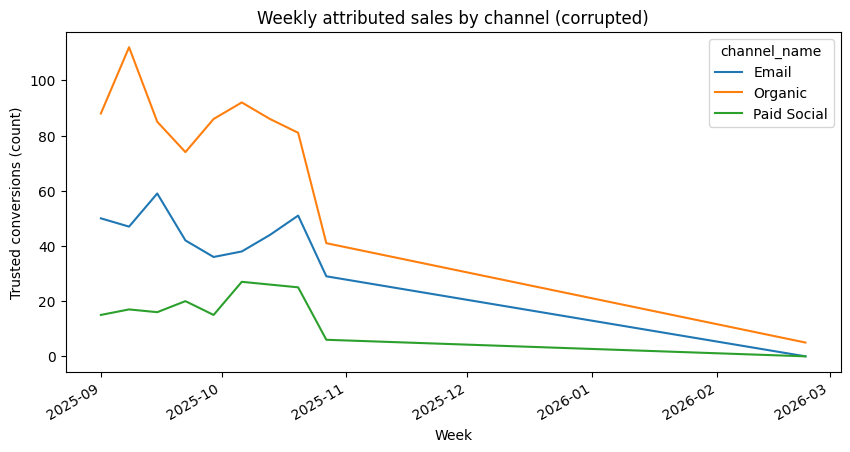

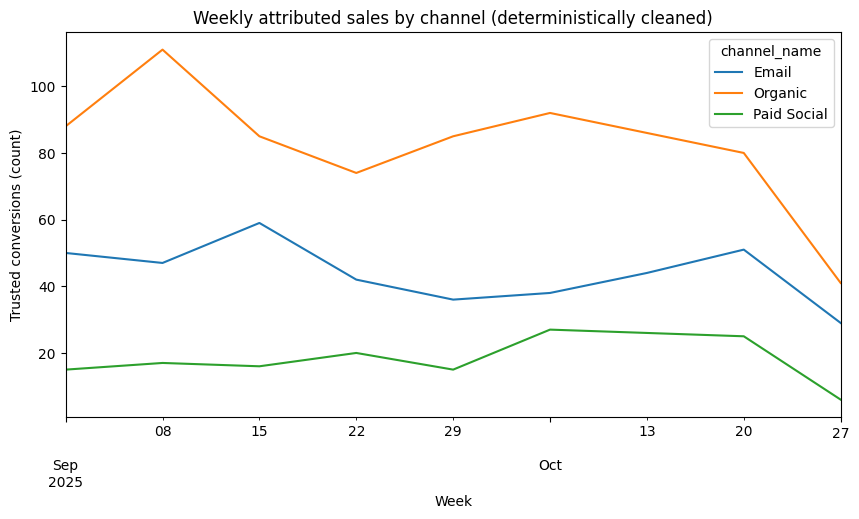

In [25]:
def deterministic_clean(
    df_sess_in: pd.DataFrame,
    df_conv_in: pd.DataFrame,
    df_chan_in: pd.DataFrame,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Deterministic cleaning using DuckDB SQL only."""
    con_clean = duckdb.connect(database=":memory:")
    con_clean.register("raw_sessions", df_sess_in)
    con_clean.register("raw_conversions", df_conv_in)
    con_clean.register("dim_channels", df_chan_in)

    # Drop future sessions
    df_sess_out = con_clean.execute(
        """
        SELECT *
        FROM raw_sessions
        WHERE CAST(ts AS TIMESTAMP) <= NOW()
        """
    ).df()

    # Drop negative revenue and orphan conversions
    df_conv_out = con_clean.execute(
        """
        SELECT c.*
        FROM raw_conversions c
        WHERE (c.revenue >= 0 OR c.revenue IS NULL)
          AND EXISTS (
                SELECT 1
                FROM raw_sessions s
                WHERE s.session_id = c.session_id
            )
        """
    ).df()

    con_clean.close()
    return df_sess_out, df_conv_out

# Apply deterministic cleaning to the corrupted copy
df_sess_det, df_conv_det = deterministic_clean(df_sess_bad, df_conv_bad, df_chan)
print("Deterministically cleaned sessions / conversions:", len(df_sess_det), len(df_conv_det))

# Quality checks AFTER deterministic cleaning
con_det = duckdb.connect(database=":memory:")
con_det.register("raw_sessions", df_sess_det)
con_det.register("raw_conversions", df_conv_det)
con_det.register("dim_channels", df_chan)

print("Quality checks on corrupted data:")
display(run_quality_checks(con_bad))
print("\nQuality checks after deterministic cleaning:")
display(run_quality_checks(con_det))

# Helper SQL for weekly trend visualization
trend_sql = """
SELECT
    DATE_TRUNC('week', CAST(session_ts AS TIMESTAMP)) AS week,
    channel_name,
    SUM(is_attributed) AS sales
FROM f_attribution
GROUP BY 1, 2
ORDER BY 1, 2
"""

# Compute weekly trends for corrupted and deterministically cleaned data
build_semantic_view(con_bad, window_days=7)
df_trend_bad = con_bad.execute(trend_sql).df()
pivot_bad = df_trend_bad.pivot(index="week", columns="channel_name", values="sales").fillna(0)

build_semantic_view(con_det, window_days=7)
df_trend_det = con_det.execute(trend_sql).df()
pivot_det = df_trend_det.pivot(index="week", columns="channel_name", values="sales").fillna(0)

# Plot corrupted data
plt.figure(figsize=(10, 5))
pivot_bad.plot(kind="line", ax=plt.gca())
plt.title("Weekly attributed sales by channel (corrupted)")
plt.ylabel("Trusted conversions (count)")
plt.xlabel("Week")
plt.show()

# Plot deterministically cleaned data
plt.figure(figsize=(10, 5))
pivot_det.plot(kind="line", ax=plt.gca())
plt.title("Weekly attributed sales by channel (deterministically cleaned)")
plt.ylabel("Trusted conversions (count)")
plt.xlabel("Week")
plt.show()

### ## Phase 5 Path B: Let's reset corrupted copy for AI cleaning demo

For the AI demo, we start again from the original clean stream and re-introduce errors, so deterministic cleaning and AI cleaning each operate on their own fresh corrupted copy.

In [26]:
# Fresh corrupted copy starting from the original clean stream for AI demo
df_sess_bad, df_conv_bad = inject_corruption(df_sess, df_conv)
print("(AI demo) sessions / conversions (corrupted):", len(df_sess_bad), len(df_conv_bad))

# Register corrupted tables for AI cleaning demo
con_bad = duckdb.connect(database=":memory:")
con_bad.register("raw_sessions", df_sess_bad)
con_bad.register("raw_conversions", df_conv_bad)
con_bad.register("dim_channels", df_chan)

run_quality_checks(con_bad)

(AI demo) sessions / conversions (corrupted): 58907 1729


/tmp/ipykernel_25356/1270338536.py:27: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  future_dupes["ts"] = dt.datetime.utcnow() + dt.timedelta(days=30)


,check,errors,status
0,Negative revenue,5,FAIL
1,Orphaned conversions,5,FAIL
2,Future session timestamps,176,FAIL


## Phase 5 Path B: Let's do some cleaning with an AI agent 
...and QA with an AI judge.

Finally, we can hand the same corrupted dataset to an **AI cleaning agent** and **AI judge** from the `ai_cleaning_agent` module.

The loop is:

1. measure quality on the current data,
2. the planner model proposes a cleaning plan (using only allowed operations),
3. Python applies the plan deterministically with DuckDB,
4. the judge model checks before/after quality metrics and row counts.

Note: This requires an OpenAI API key in the environment variable `OPENAI_API_KEY`. If the key is missing, the cell will skip the AI step:

use export OPENAI_API_KEY="your_openai_api_key_here" in CLI before running the next cell.

You can use other AI providers of span your own model, such as Gemini, Gemma, or LLaMA. Here we just use OpenAI mini model because it's cheap yet powerful enough. 

[AI CLEANING] Iteration 1 - checks_before: {'negative_revenue': 5, 'orphaned_conversions': 5, 'invalid_session_timestamps': 0, 'future_session_timestamps': 176}
[AI CLEANING] Iteration 1 - checks_after: {'negative_revenue': 0, 'orphaned_conversions': 0, 'invalid_session_timestamps': 0, 'future_session_timestamps': 0}, verdict: pass
=== AI Cleaning Plan ===
Version: 1.0
Notes: Apply targeted drops that remove only problematic records to bring all quality check counts to zero while minimizing data loss. Plan: 1) remove sessions with timestamps in the future (176), 2) remove conversions with negative revenue (5), 3) remove orphaned conversions that reference no session (5). After these three targeted drops the four quality checks will be zeroed.
Steps:
  1. op=drop_future_sessions args={'criterion': 'ts > 2026-01-29T18:10:42Z', 'expected_removed': 176, 'rationale': 'Remove only sessions whose timestamps are in the future relative to now; preserves all valid historical sessions.'}
  2. op=

,check,errors,status
0,Negative revenue,5,FAIL
1,Orphaned conversions,5,FAIL
2,Future session timestamps,176,FAIL



Quality checks AFTER AI cleaning:


,check,errors,status
0,Negative revenue,0,PASS
1,Orphaned conversions,0,PASS
2,Future session timestamps,0,PASS


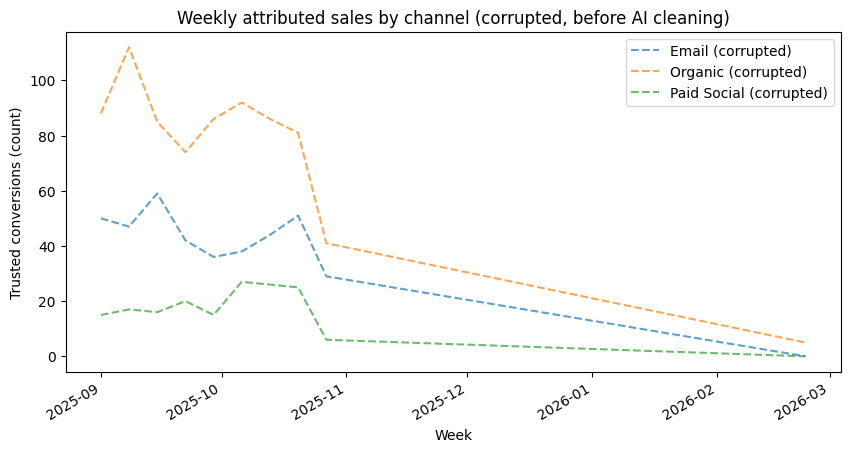

In [27]:
import os
from ai_cleaning_agent import run_agentic_cleaning_loop

if os.getenv("OPENAI_API_KEY", "").strip():
    ai_result = run_agentic_cleaning_loop(
        sessions=df_sess_bad,
        conversions=df_conv_bad,
        channels=df_chan,
        planner_model="gpt-5-mini",
        judge_model="gpt-5-mini",
        max_iters=2,
    )

    # --- Make AI reasoning explicit ---
    plan = ai_result.get("plan", {})
    judge = ai_result.get("judge", {})

    print("=== AI Cleaning Plan ===")
    print(f"Version: {plan.get('version')}")
    print(f"Notes: {plan.get('notes')}")
    print("Steps:")
    for i, step in enumerate(plan.get("steps", []), 1):
        op = step.get("op")
        args = step.get("args")
        print(f"  {i}. op={op} args={args}")

    print("\n=== AI Judge Verdict ===")
    print(f"Verdict: {judge.get('verdict')}")
    reasons = judge.get("reasons") or []
    if reasons:
        print("Reasons:")
        for r in reasons:
            print(f"  - {r}")
    next_action = judge.get("next_action")
    if next_action:
        print("Next action:", next_action)

    # --- Tables cleaned by the AI agent ---
    df_sess_ai = ai_result["sessions_clean"]
    df_conv_ai = ai_result["conversions_clean"]

    con_ai = duckdb.connect(database=":memory:")
    con_ai.register("raw_sessions", df_sess_ai)
    con_ai.register("raw_conversions", df_conv_ai)
    con_ai.register("dim_channels", df_chan)

    print("\nQuality checks BEFORE (corrupted):")
    display(run_quality_checks(con_bad))
    print("\nQuality checks AFTER AI cleaning:")
    display(run_quality_checks(con_ai))

    # Visualize weekly conversions before AI cleaning
    plt.figure(figsize=(10, 5))

    build_semantic_view(con_bad, window_days=7)
    df_trend_bad_ai = con_bad.execute(trend_sql).df()
    pivot_bad_ai = df_trend_bad_ai.pivot(index="week", columns="channel_name", values="sales").fillna(0)
    pivot_bad_ai.plot(kind="line", ax=plt.gca(), linestyle="--", alpha=0.7)

    plt.title("Weekly attributed sales by channel (corrupted, before AI cleaning)")
    plt.ylabel("Trusted conversions (count)")
    plt.xlabel("Week")
    plt.legend([f"{c} (corrupted)" for c in pivot_bad_ai.columns])
    plt.show()
else:
    print("OPENAI_API_KEY is not set. Skipping AI cleaning demo.")

## Phase 5 Path B: Let's visualize the results cleaned by the AI agent

Finally, we visualize the weekly attributed sales by channel for the corrupted data before and after AI cleaning.

Congratulations! You have built a reliable engine for marketing KPIs!

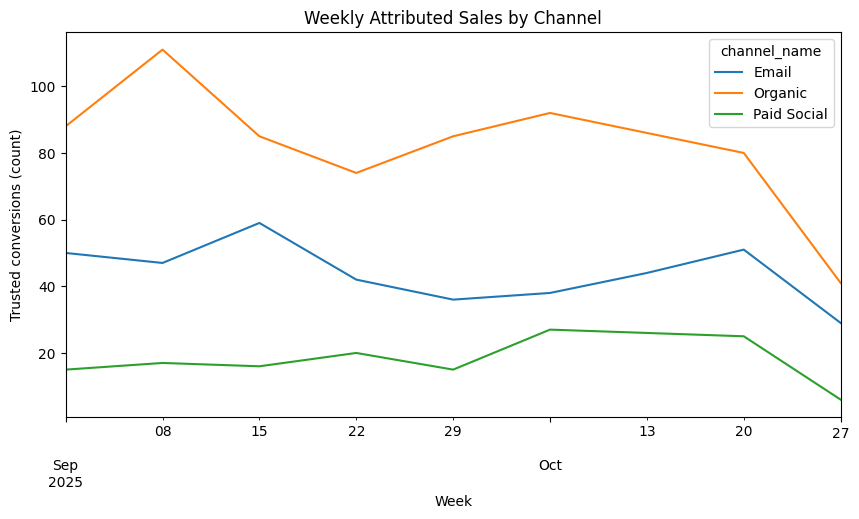

In [28]:
build_semantic_view(con, window_days=7)

trend_sql = """
SELECT
    DATE_TRUNC('week', session_ts) AS week,
    channel_name,
    SUM(is_attributed) AS sales
FROM f_attribution
GROUP BY 1, 2
ORDER BY 1, 2
"""
df_viz = con.execute(trend_sql).df()

pivot = df_viz.pivot(index="week", columns="channel_name", values="sales").fillna(0)
pivot.plot(kind="line", figsize=(10, 5), title="Weekly Attributed Sales by Channel")
plt.ylabel("Trusted conversions (count)")
plt.xlabel("Week")
plt.show()
